In [62]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download(['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger'])
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stefaniamindoiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefaniamindoiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stefaniamindoiu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/stefaniamindoiu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [63]:
df = pd.read_csv('results.csv')
df.shape

(132, 4)

In [64]:
def tokenize(text):
    lemmatizer = WordNetLemmatizer()

    text = text.lower()
    text = re.sub("[^a-zA-Z0-9]", " ", text)

    words_list = word_tokenize(text)
    words_list = [lemmatizer.lemmatize(word) for word in words_list]
    tags = nltk.pos_tag(words_list)

    words_list = [tag[0] for tag in tags if tag[1].startswith('NN') or tag[1].startswith('JJ')]

    return words_list

In [65]:
def get_all_tokens():
    all_tokens = []
    for i in range(0,df.shape[0]):
        all_tokens.extend(tokenize(df.Description[i]))
       
    all_tokens = set(all_tokens)
    all_tokens.remove('i')
    all_tokens.remove('s')
    
    all_tokens = list(all_tokens)
    all_tokens.sort()
    
    return all_tokens

In [66]:
all_tokens = get_all_tokens()

In [67]:
def generate_feature_columns(df):
    new_df = pd.DataFrame(columns=all_tokens)
    
    for i in range(0, df.shape[0]):
        tokens = tokenize(df.Description[i])
        for token in all_tokens:
            new_df.loc[i, token] = 1 if token in tokens else 0
            
    return new_df

In [68]:
df = pd.concat([df, generate_feature_columns(df)], axis=1)

In [69]:
df.head()

,Id,Description,Name,UploadDate,actual,adult,airplane,aluminium,apple,art,...,wheel,white,window,wine,winter,woman,wood,worldwide,yellow,zero
0,600b30b4-54fc-4b1f-b439-9443585ba1ef,"""This building is a monastery. """,20210730_111229.jpg,2023-07-25 13:00:36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,04f79ce4-c849-4deb-b856-8d488d214e03,Blue budgie bird in a cage,IMG_2659.jpeg,2023-07-25 18:49:45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,edc7dd62-07c0-4d31-97da-8e9430f28d0c,"""Ruins of a Greek castle """,92822E4A-AA52-4FAE-B205-449D15021D69.jpeg,2023-07-26 10:04:20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,e6e77860-44c4-4af8-b084-3922014eefc8,"""Hand holding baby stroller etiquette """,0E00DA94-DD3D-4A4D-BB69-77638D776AA9.jpeg,2023-07-26 08:41:36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26e51c81-1135-43aa-b523-d9083d3c4838,Roller skates. Feet resting.,FB214258-7B71-4D08-AB5F-4B9243763DB4.jpeg,2023-07-26 08:46:53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
images_list = []
for i in range(0, df.shape[0]):
    img = image.load_img('./images/' + df['Id'][i])
    img = image.img_to_array(img)
    img = img/255
    images_list.append(img)

In [71]:
def getMinSize(images_list):
    min_width = 100000;
    min_height = 100000;
    
    for i in range(0, len(images_list)):
        if (images_list[i].shape[0] < min_width):
            min_width = images_list[i].shape[0]
        if (images_list[i].shape[1] < min_height):
            min_height = images_list[i].shape[1]
            
    return min_width, min_height

In [72]:
size = getMinSize(images_list)

In [73]:
images_list_resized = [image.smart_resize(img, size) for img in images_list]

In [74]:
images_list[0].shape

(3096, 4128, 3)

In [75]:
images_list_resized[0].shape

(367, 400, 3)

In [76]:
X = np.array(images_list_resized)

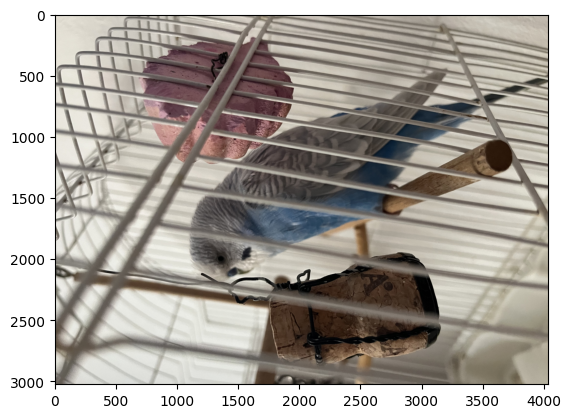

In [79]:
# Show original image
plt.imshow(np.array(images_list[1]))

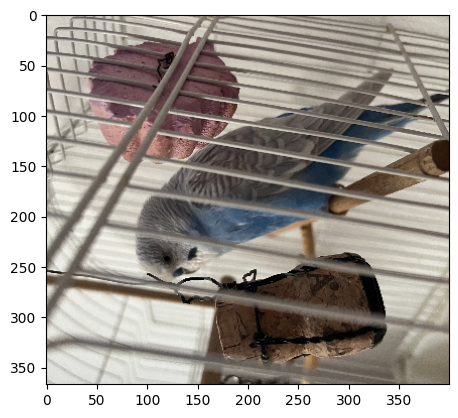

In [77]:
# Show resized image
plt.imshow(X[1])

In [80]:
y = np.array(df.drop(['Id', 'Description', 'Name', 'UploadDate'],axis=1))
y.shape

(132, 287)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [82]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=images_list_resized[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='sigmoid'))

In [83]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 363, 396, 16)      1216      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 181, 198, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 181, 198, 16)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 177, 194, 32)      12832     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 88, 97, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 88, 97, 32)       

In [84]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [85]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [86]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/10
2/2 [==============================] - 7s 3s/step - loss: 0.4487 - accuracy: 0.0000e+00 - val_loss: 0.0967 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 10s 5s/step - loss: 0.1534 - accuracy: 0.0000e+00 - val_loss: 0.0661 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 11s 5s/step - loss: 0.1334 - accuracy: 0.0000e+00 - val_loss: 0.2084 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 11s 5s/step - loss: 0.0707 - accuracy: 0.0000e+00 - val_loss: 0.4343 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 11s 5s/step - loss: 0.1021 - accuracy: 0.0000e+00 - val_loss: 0.3353 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 11s 5s/step - loss: 0.0700 - accuracy: 0.0085 - val_loss: 0.1512 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 11s 5s/step - loss: 0.0729 - accuracy: 0.0254 - val_loss: 0.0986 - val_accuracy

In [87]:
df.head()

,Id,Description,Name,UploadDate,actual,adult,airplane,aluminium,apple,art,...,wheel,white,window,wine,winter,woman,wood,worldwide,yellow,zero
0,600b30b4-54fc-4b1f-b439-9443585ba1ef,"""This building is a monastery. """,20210730_111229.jpg,2023-07-25 13:00:36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,04f79ce4-c849-4deb-b856-8d488d214e03,Blue budgie bird in a cage,IMG_2659.jpeg,2023-07-25 18:49:45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,edc7dd62-07c0-4d31-97da-8e9430f28d0c,"""Ruins of a Greek castle """,92822E4A-AA52-4FAE-B205-449D15021D69.jpeg,2023-07-26 10:04:20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,e6e77860-44c4-4af8-b084-3922014eefc8,"""Hand holding baby stroller etiquette """,0E00DA94-DD3D-4A4D-BB69-77638D776AA9.jpeg,2023-07-26 08:41:36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26e51c81-1135-43aa-b523-d9083d3c4838,Roller skates. Feet resting.,FB214258-7B71-4D08-AB5F-4B9243763DB4.jpeg,2023-07-26 08:46:53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
def getTopLabels(pred, all_tokens):
    df = pd.DataFrame(columns=all_tokens)
    df.loc[0] = pred[0]
    
    labels = list(df.iloc[:, np.argsort(df.loc[0])].columns[-3:])
    labels.reverse()
    values = list(df.iloc[0, np.argsort(df.loc[0])][-3:])
    values.reverse()
    
    return labels, values

In [89]:
# Predict labels for first image
pred = model.predict(np.array([images_list_resized[0]]))
labels, values = getTopLabels(pred, all_tokens)
print(labels)
print(values)

1/1 [==============================] - 0s 59ms/step
['view', 'dog', 'blue']
[0.3303412199020386, 0.3292022943496704, 0.32815006375312805]


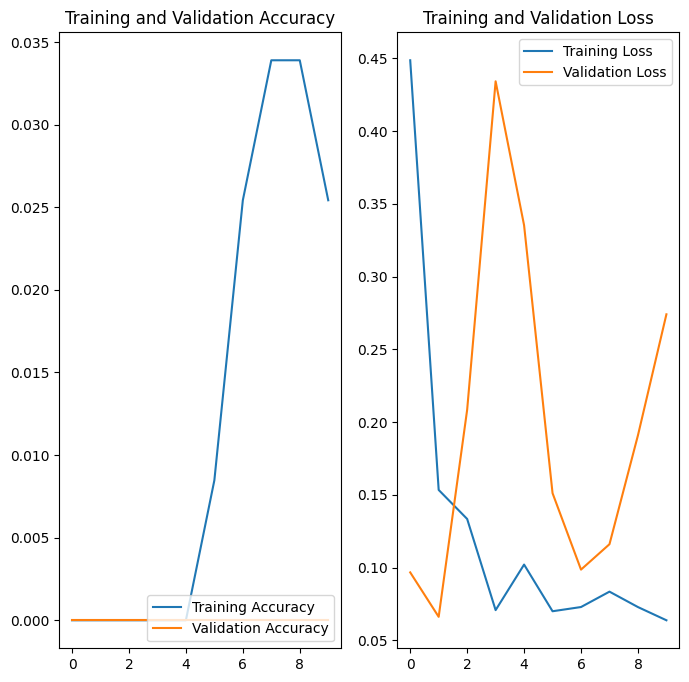

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [91]:
model.evaluate(X_test, y_test, verbose=0)

[0.2741056978702545, 0.0]

In [679]:
model.save('model-image-description.h5')

In [789]:
np.save('labels', np_all_tokens)
np.load('labels.npy')

array(['actual', 'adult', 'airplane', 'aluminium', 'apple', 'art',
       'artefact', 'artist', 'autumn', 'baby', 'background', 'baloons',
       'bamboo', 'behind', 'bell', 'bench', 'bicycle', 'bird', 'birthday',
       'bit', 'black', 'blackberry', 'block', 'blue', 'board', 'boat',
       'bonsai', 'book', 'bookcase', 'border', 'botanic', 'botanical',
       'bottle', 'bouquet', 'bowl', 'branch', 'bridge', 'brown', 'budgie',
       'building', 'butterfly', 'cactus', 'cage', 'candle', 'car',
       'carpet', 'cassette', 'castle', 'cat', 'cebazan', 'centre',
       'chair', 'chicken', 'child', 'christ', 'church', 'city', 'closeup',
       'clothes', 'cloud', 'cloudy', 'coffee', 'concert', 'consists',
       'cross', 'crossing', 'cucunbers', 'danube', 'dog', 'door', 'drawn',
       'duck', 'egg', 'eifel', 'electrical', 'empty', 'estate',
       'etiquette', 'eye', 'field', 'finger', 'first', 'fish', 'flat',
       'floor', 'flower', 'foil', 'food', 'foot', 'forest', 'france',
       'fr